<a href="https://colab.research.google.com/github/ShawnLiu119/Chatbot_CardBenefit_LLM_MilvusRAG/blob/main/Chatbot_CreditCardQA_RAG_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chatbot to answer credit card questions = LLM + Vector DB (RAG)**

 The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.


*   embedding model
*   Generative AI model




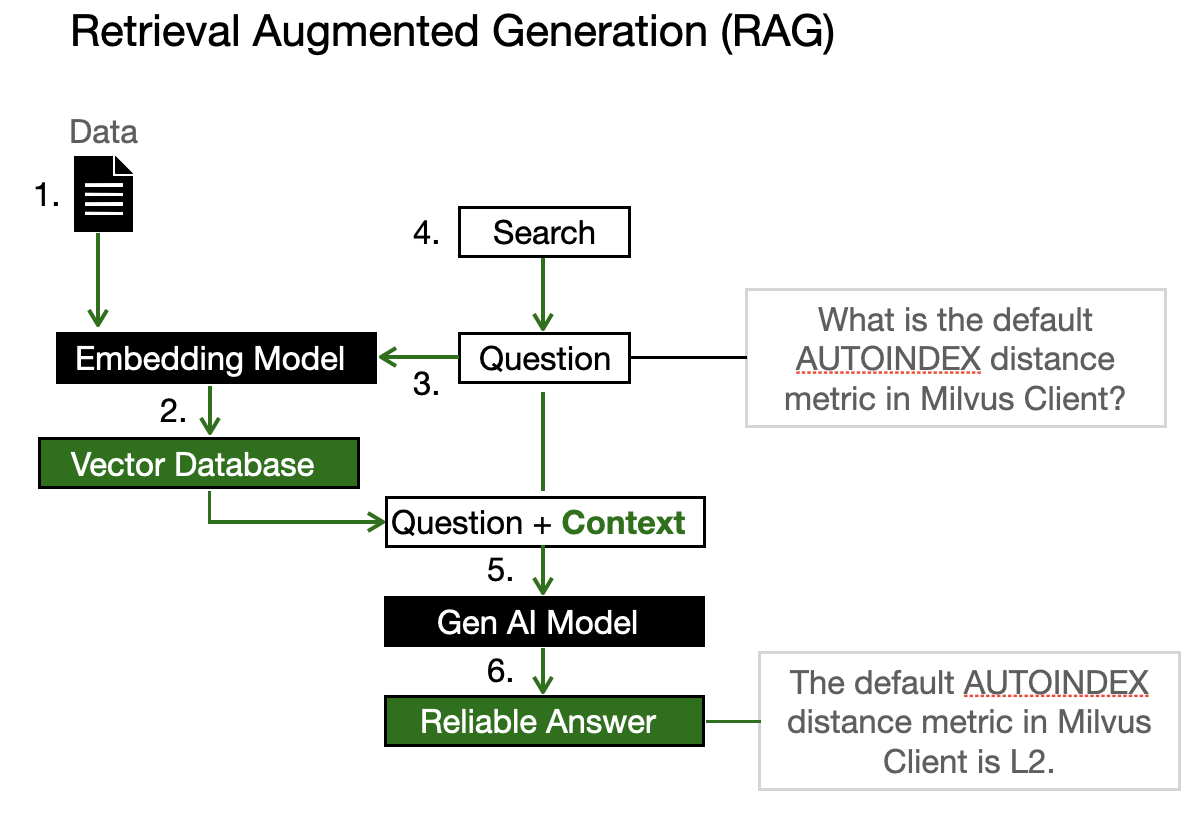

reference source code:
https://github.com/milvus-io/bootcamp/tree/master/bootcamp/RAG

In [3]:
# For colab install these libraries in this order:
!python -m pip install torch transformers sentence-transformers langchain

In [4]:
!python -m pip install -U pymilvus 'pymilvus[model]'

In [5]:
!python -m pip install unstructured openai tqdm numpy ipykernel

In [6]:
# Import common libraries.
import sys, os, time, pprint
import numpy as np

## Step 1: Prep Data for Vector Database Embedding

In [7]:
!pip install langchain-community langchain-core

In [8]:
from langchain_community.document_loaders import RecursiveUrlLoader, WebBaseLoader

#relevant data regarding Fingerhut credit card offering
DOCS_PAGE=[
    "https://www.fingerhut.com/content/footer-terms",
    "https://www.fingerhut.com/content/CreditTC?pageName=CreditTC",
    "https://www.fingerhut.com/content/faqs-fetti",
    "https://www.fingerhut.com/content/faqs-payments-balance-account-info"
]

loader = WebBaseLoader(DOCS_PAGE)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")


loaded 4 documents


## Step 2: Set up Milvus
There are several ways of running Milvus:

1.   local Docker (recommended)
2.   Zilliz free tier
3.   from Colab (https://milvus.io/docs/quickstart.md)

 Milvus Lite, a python library included in pymilvus that can be embedded into the client application. Milvus also supports deployment on Docker and Kubenetes for production use cases


In [12]:
!pip install -U pymilvus

## Step 3: Load the Embedding Model

An excellent place to start is by selecting an embedding model from the HuggingFace MTEB Leaderboard(https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.

In this notebook, we will use the open-source **BGE-M3** which supports:<br>
over 100 languages <br>
context lengths of up to 8192 <br>
multiple embedding inferences such as dense (semantic), sparse (lexical), and multi-vector Colbert reranking.<br>
BGE-M3 holds the distinction of being the first embedding model to offer support for all three retrieval methods, achieving state-of-the-art performance on multi-lingual (MIRACL) and cross-lingual (MKQA) benchmark tests.

Embedding function supported by Milvus:<br>
https://github.com/milvus-io/bootcamp/blob/master/bootcamp/model/embedding_functions.ipynb

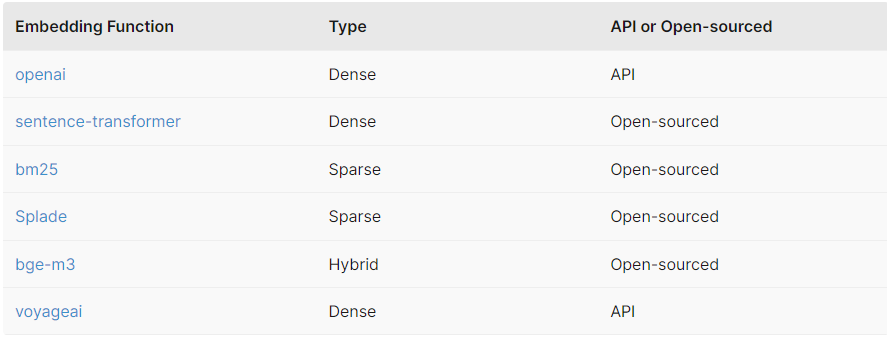

In [ ]:
#open AI embedding function

# from pymilvus import model

# # initialize using 'text-embedding-3-large'
# openai_ef = model.dense.OpenAIEmbeddingFunction(
#     model_name="text-embedding-3-large", # Specify the model name
#     dimensions=512 # Set the embedding dimensionality according to MRL feature.
# )

# # get the embeddings in general way.
# queries = docs
# queries_embeddings = openai_ef(queries)
# docs_embeddings = openai_ef(docs)

# # get the embeddings in specified way.
# queries_embeddings = openai_ef.encode_queries(queries)
# docs_embeddings = openai_ef.encode_documents(docs)

# # now we can check the dimension of embedding from results and the embedding function.
# print("dense dim:", openai_ef.dim, queries_embeddings[0].shape)
# print("dense dim:", openai_ef.dim, docs_embeddings[0].shape)

In [ ]:
# please set the use_fp16 to False when you are using cpu.
# by default the return options is:
#  return_dense True
#  return_sparse True
#  return_colbert_vecs False
# bge_m3_ef = BGEM3EmbeddingFunction(
#     model_name='BAAI/bge-m3', # Specify the model name
#     device='cpu', # Specify the device to use, e.g., 'cpu' or 'cuda:0'
#     use_fp16=False # Specify whether to use fp16. Set to `False` if `device` is `cpu`.
# )

CUDA® is a parallel computing platform and programming model developed by NVIDIA for general computing on graphical processing units (GPUs).

In [1]:
#compatible issue
#(grpcio 1.64.0 (/usr/local/lib/python3.10/dist-packages) -->Google Colab environment, Requirement.parse('grpcio<=1.63.0,>=1.49.1'), {'pymilvus'})
#error debug: https://github.com/deepset-ai/haystack/issues/1351
!pip install grpcio==1.63.0
!pip install grpcio-tools==1.63.0

In [10]:
torch.cuda.is_available()

True

In [11]:
#download embedding model

from pymilvus.model.hybrid import BGEM3EmbeddingFunction
import torch

# Initialize torch settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {DEVICE}")

# Initialize a Milvus built-in sparse-dense-reranking encoder.
# https://huggingface.co/BAAI/bge-m3
embedding_model = BGEM3EmbeddingFunction(use_fp16=True, device=DEVICE)
EMBEDDING_DIM = embedding_model.dim['dense']
print(f"dense_dim: {EMBEDDING_DIM}")
print(f"sparse_dim: {embedding_model.dim['sparse']}")
print(f"colbert_dim: {embedding_model.dim['colbert_vecs']}")

device: cuda


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

dense_dim: 1024
sparse_dim: 250002
colbert_dim: 1024


## Step 4: Create Milvus Collection

The collection will contain the

**Schema** (or no-schema Milvus client).
💡 You'll need the vector EMBEDDING_DIM parameter from your embedding model. Typical values are: <br>
**1024 for sbert embedding models**<br>
**1536 for ada-002 OpenAI embedding models**<br>
**Vector index** for efficient vector search (https://www.youtube.com/watch?v=dN0lsF2cvm4)<br>
**Vector distance metric** for measuring nearest neighbor vectors<br>
**Consistency level** In Milvus, transactional consistency is possible; however, according to the CAP theorem, some latency must be sacrificed. 💡 Searching movie reviews is not mission-critical, so eventually consistent is fine here.

### **Add a Vector Index**
The vector index determines the vector search algorithm used to find the closest vectors in your data to the query a user submits.<br>

**Most of the vector index types supported by Milvus use approximate nearest neighbors search (ANNS) algorithms**. Compared with accurate retrieval, which is usually very time-consuming, the core idea of ANNS is no longer limited to returning the most accurate result, but only searching for neighbors of the target. ANNS improves retrieval efficiency by sacrificing accuracy within an acceptable range.<br>

**According to the implementation methods, the ANNS vector index can be divided into four categories:**<br>
**Tree-based index**<br>
**Graph-based index**<br>
**Hash-based index**<br>
**Quantization-based index**<br>

Most vector indexes use different sets of parameters depending on whether the database is:<br>

inserting vectors (creation mode) - vs -<br>
searching vectors (search mode)<br>

Indexing approach supported by Milvus.https://milvus.io/docs/index.md#floating

Besides a search algorithm, we also need to specify a **distance metric, that is, a definition of what is considered "close" in vector space.** In the cell below, the HNSW search index is chosen. Its possible distance metrics are one of:<br>

L2 - L2-norm<br>
IP - Dot-product<br>
COSINE - Angular distance<br>
💡 Most use cases work better with normalized embeddings, in which case L2 is useless (every vector has length=1) and IP and COSINE are the same. Only choose L2 if you plan to keep your embeddings unnormalized.

In [19]:
# STEP 3. CREATE A NO-SCHEMA Fingerhut COLLECTION AND DEFINE THE DATABASE INDEX.
# See docstrings for more information.
# https://github.com/milvus-io/pymilvus/blob/master/examples/hello_hybrid_sparse_dense.py

# from pymilvus import MilvusClient, Collection, FieldSchema, DataType, CollectionSchema, utility

# client = MilvusClient("credit_card.db")

# # Set the Milvus collection name.
# COLLECTION_NAME = "FingerhutCreditCard"

# # Specify the data schema for the new Collection.
# MAX_LENGTH = 65535
# fields = [
#     # Use auto generated id as primary key
#     FieldSchema(name="id", dtype=DataType.INT64,
#                 is_primary=True, auto_id=True, max_length=100),
#     FieldSchema(name="sparse_vector", dtype=DataType.SPARSE_FLOAT_VECTOR),
#     FieldSchema(name="dense_vector", dtype=DataType.FLOAT_VECTOR,
#                 dim=EMBEDDING_DIM),
#     FieldSchema(name="chunk", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
#     FieldSchema(name="source", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
#     FieldSchema(name="h1", dtype=DataType.VARCHAR, max_length=100),
#     FieldSchema(name="h2", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
# ]
# schema = CollectionSchema(fields, "")

# # Check if collection already exists, if so drop it.
# has = utility.has_collection(COLLECTION_NAME)
# if has:
#     drop_result = utility.drop_collection(COLLECTION_NAME)
#     print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

# # Create the collection.
# schema = CollectionSchema(fields, "")
# # col = Collection(COLLECTION_NAME, schema, consistency_level="Eventually")

# col = client.create_collection(
#     collection_name=COLLECTION_NAME,
#     schema,
#     consistency_level=3)


# # Add custom HNSW search index to the collection. HNSW - Graph index (stochastic approximate search)
# # M = max number graph connections per layer. Large M = denser graph.
# # Choice of M: 4~64, larger M for larger data and larger embedding lengths.
# M = 16
# # efConstruction = num_candidate_nearest_neighbors per layer.
# # Use Rule of thumb: int. 8~512, efConstruction = M * 2.
# efConstruction = M * 2
# # Create the search index for local Milvus server.
# INDEX_PARAMS = dict({
#     'M': M,
#     "efConstruction": efConstruction })

# # Create indices for the vector fields.
# # The indices will pre-load data into memory for efficient search.
# sparse_index = {"index_type": "SPARSE_INVERTED_INDEX", "metric_type": "IP"}
# dense_index = {"index_type": "HNSW", "metric_type": "COSINE", "params": INDEX_PARAMS}
# col.create_index("sparse_vector", sparse_index)
# col.create_index("dense_vector", dense_index)
# col.load()

# print(f"Successfully created collection: `{COLLECTION_NAME}`")

SyntaxError: positional argument follows keyword argument (<ipython-input-19-0b1e96868ee0>, line 41)

In [23]:
#rewrite this in Milvus Lite SDK syntax
#https://milvus.io/api-reference/pymilvus/v2.4.x/MilvusClient/Collections/create_collection.md

from pymilvus import MilvusClient, Collection, FieldSchema, DataType, CollectionSchema, utility

client = MilvusClient("credit_card.db")

COLLECTION_NAME = "FingerhutCreditCard"

# 1. Create schema
schema = MilvusClient.create_schema(
    auto_id=True,
    enable_dynamic_field=False,
)

# 2. Add fields to schema
MAX_LENGTH = 65535
schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True, max_length=100)
schema.add_field(field_name="sparse_vector", datatype=DataType.SPARSE_FLOAT_VECTOR)
schema.add_field(field_name="dense_vector", datatype=DataType.FLOAT_VECTOR, dim=EMBEDDING_DIM)
schema.add_field(field_name="chunk", datatype=DataType.VARCHAR, max_length=MAX_LENGTH)
schema.add_field(field_name="source", datatype=DataType.VARCHAR, max_length=MAX_LENGTH),
schema.add_field(field_name="h1", datatype=DataType.VARCHAR, max_length=100),
schema.add_field(field_name="h2", datatype=DataType.VARCHAR, max_length=MAX_LENGTH),

# 3. Prepare index parameters
index_params = client.prepare_index_params()

# Add custom HNSW search index to the collection. HNSW - Graph index (stochastic approximate search)
# M = max number graph connections per layer. Large M = denser graph.
# Choice of M: 4~64, larger M for larger data and larger embedding lengths.
M = 16
# efConstruction = num_candidate_nearest_neighbors per layer.
# Use Rule of thumb: int. 8~512, efConstruction = M * 2.
efConstruction = M * 2
# Create the search index for local Milvus server.
DENSE_PARAMS = dict({
    'M': M,
    "efConstruction": efConstruction })

# 4. Add indexes
index_params.add_index(
    field_name="dense_vector",
    index_type="HNSW",
    metric_type="COSINE",
    params=DENSE_PARAMS
)

index_params.add_index(
    field_name="sparse_vector",
    index_type="SPARSE_INVERTED_INDEX",
    metric_type="IP"
    # params={"nlist": 1024}
)

# 5. Create a collection
client.create_collection(
    collection_name=COLLECTION_NAME,
    schema=schema
)

# 6. Create indexes
client.create_index(
    collection_name=COLLECTION_NAME,
    index_params=index_params
)

# 6. List indexes
client.list_indexes(collection_name=COLLECTION_NAME)

DEBUG:pymilvus.milvus_client.milvus_client:Created new connection using: 4e412aeacdb04a4e9d322073d3d1d6cf
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created collection: FingerhutCreditCard
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: FingerhutCreditCard
DEBUG:pymilvus.milvus_client.milvus_client:Successfully created an index on collection: FingerhutCreditCard


['dense_vector', 'sparse_vector']